# Domino Image Classification

In [27]:
import os
import cv2
import re
import torch
import os
import zipfile
import requests
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

## Set up domino dataset class

In [28]:
dominoMap = {
    (0,0): 0,
    (0,1): 1,
    (0,2): 2,
    (1,1): 3,
    (1,2): 4,
    (2,2): 5
}

In [29]:
# Define dataset class
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((128, 128)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_file_path = self.image_paths[idx]
        image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        image = self.transform(image)

        match = re.search(r'(\d+)-(\d+)', image_file_path)
        if not match:
            raise ValueError(f'Invalid image file path: {image_file_path}')
        num1, num2 = map(int, match.groups())

        # Get label
        label = dominoMap[(num1, num2)]

        return image, torch.tensor(label, dtype=torch.long)
        

## Load data from kaggle

In [30]:
# Load dataset
if not os.path.exists('./data'):
    response = requests.get('https://www.kaggle.com/api/v1/datasets/download/mattqgoldberg/double-2-dominoes')

    with open('./double-2-dominoes.zip', 'wb') as f:
        f.write(response.content)



    with zipfile.ZipFile('./double-2-dominoes.zip', 'r') as zip_ref:
        zip_ref.extractall('./data')

else:
    print('Data already exists')

Data already exists


In [31]:
# Load dataset from multiple directories

dataset_paths = ['./data/images']

image_paths = []
for path in dataset_paths:
    for subdir in os.listdir(path):
        if os.path.isdir(os.path.join(path, subdir)):
            for img in os.listdir(os.path.join(path, subdir)):
                image_paths.append(os.path.join(path, subdir, img))
            

# Split into training and testing sets
train_images, test_images = train_test_split(image_paths, test_size=0.2)

# Create train and test datasets
train_dataset = CustomDataset(train_images, "")
test_dataset = CustomDataset(test_images, "")

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Num images in train set: {len(train_loader.dataset)}")
print(f"Num images in test set: {len(test_loader.dataset)}")




Num images in train set: 1176
Num images in test set: 295


## Visualize a sample image and transform it

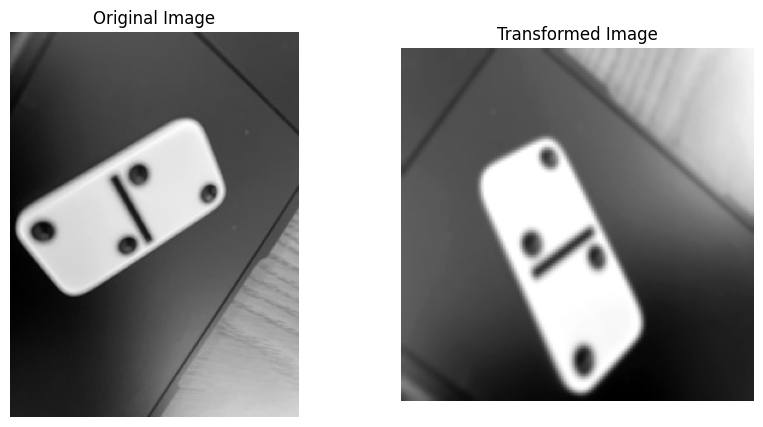

In [32]:
# Get a random image from the training dataset
random_idx = random.randint(0, len(train_dataset) - 1)
image_path = train_dataset.image_paths[random_idx]

# Load the original image
original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image = original_image.copy()
image = Image.fromarray(image)

# Apply transformations
transform_pipeline = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((128, 128)),
            transforms.GaussianBlur(kernel_size=3),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5]),
        ])

transformed_image = transform_pipeline(image)

# Convert tensors back to images for visualization
def tensor_to_image(tensor):
    tensor = tensor.squeeze(0)  # Remove channel dimension
    tensor = tensor * 0.5 + 0.5  # Undo normalization
    return tensor.numpy()

# Plot original and transformed images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show original image
axes[0].imshow(original_image, cmap="gray")
axes[0].set_title("Original Image")
axes[0].axis("off")

# Show transformed image
axes[1].imshow(tensor_to_image(transformed_image.T), cmap="gray")
axes[1].set_title("Transformed Image")
axes[1].axis("off")

# Display the images
plt.show()


## Create CNN Model Class

In [ ]:
class PipCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(PipCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(32)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(128)

        # Fourth Convolutional Block
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling Layer
        self.pool = nn.MaxPool2d(2, 2)

        # Global Average Pooling (GAP)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully Connected Layers
        self.fc1 = nn.Linear(256, 128)
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # First Block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn1_2(self.conv1_2(x))))

        # Second Block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn2_2(self.conv2_2(x))))

        # Third Block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn3_2(self.conv3_2(x))))

        # Fourth Block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Global Average Pooling (GAP)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flatten along the channel dimension

        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## Train model

In [ ]:
# Initialize model, loss function, and optimizer
epochs = 10
lr = 0.001
weight_decay = 1e-3

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = PipCNN(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)


loss_list = []
acc_list = []

# Train the model
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    avg_loss = 0
    avg_acc = 0

    # Iterate over the training dataset
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
    
    # Calculate average loss and accuracy
    train_accuracy = correct_predictions / total_samples
    acc_list.append(train_accuracy)
    loss_list.append(total_loss/len(train_loader))
    
    scheduler.step()    

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")


Epoch 1/10, Loss: 1.7925, Train Accuracy: 0.1973
Epoch 2/10, Loss: 1.5466, Train Accuracy: 0.3333
Epoch 3/10, Loss: 1.3611, Train Accuracy: 0.3784
Epoch 4/10, Loss: 1.1736, Train Accuracy: 0.4609
Epoch 5/10, Loss: 0.9851, Train Accuracy: 0.5791
Epoch 6/10, Loss: 0.8514, Train Accuracy: 0.6565
Epoch 7/10, Loss: 0.7300, Train Accuracy: 0.7024
Epoch 8/10, Loss: 0.5991, Train Accuracy: 0.7781
Epoch 9/10, Loss: 0.5506, Train Accuracy: 0.8112
Epoch 10/10, Loss: 0.5154, Train Accuracy: 0.8248


## Graph Training results

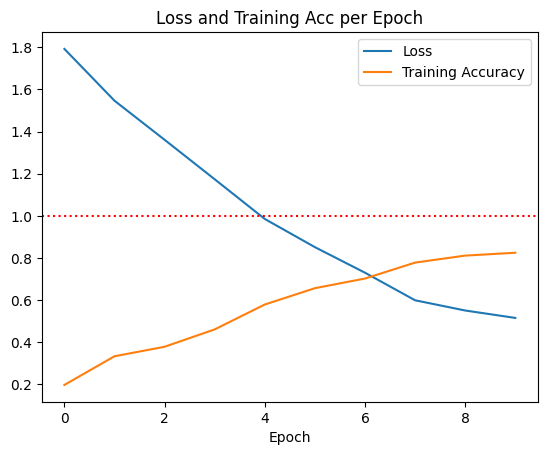

In [35]:
def graph_loss_and_accuracy(loss_list, acc_list):
    plt.plot(loss_list, label='Loss')
    plt.plot(acc_list, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.title('Loss and Training Acc per Epoch')
    plt.axhline(y=1, color='r', linestyle=':')
    plt.legend()
    plt.show()

graph_loss_and_accuracy(loss_list, acc_list)


## Evaluate against the test set

In [36]:
# Run evaluation on the test set
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predictions = torch.argmax(outputs, dim=1)
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = test_correct / test_total

print(f"Test Accuracy: {test_accuracy:.4f}, Test Correct: {test_correct}, Test Total: {test_total}")

Test Accuracy: 0.9356, Test Correct: 276, Test Total: 295


## Show some sample predictions

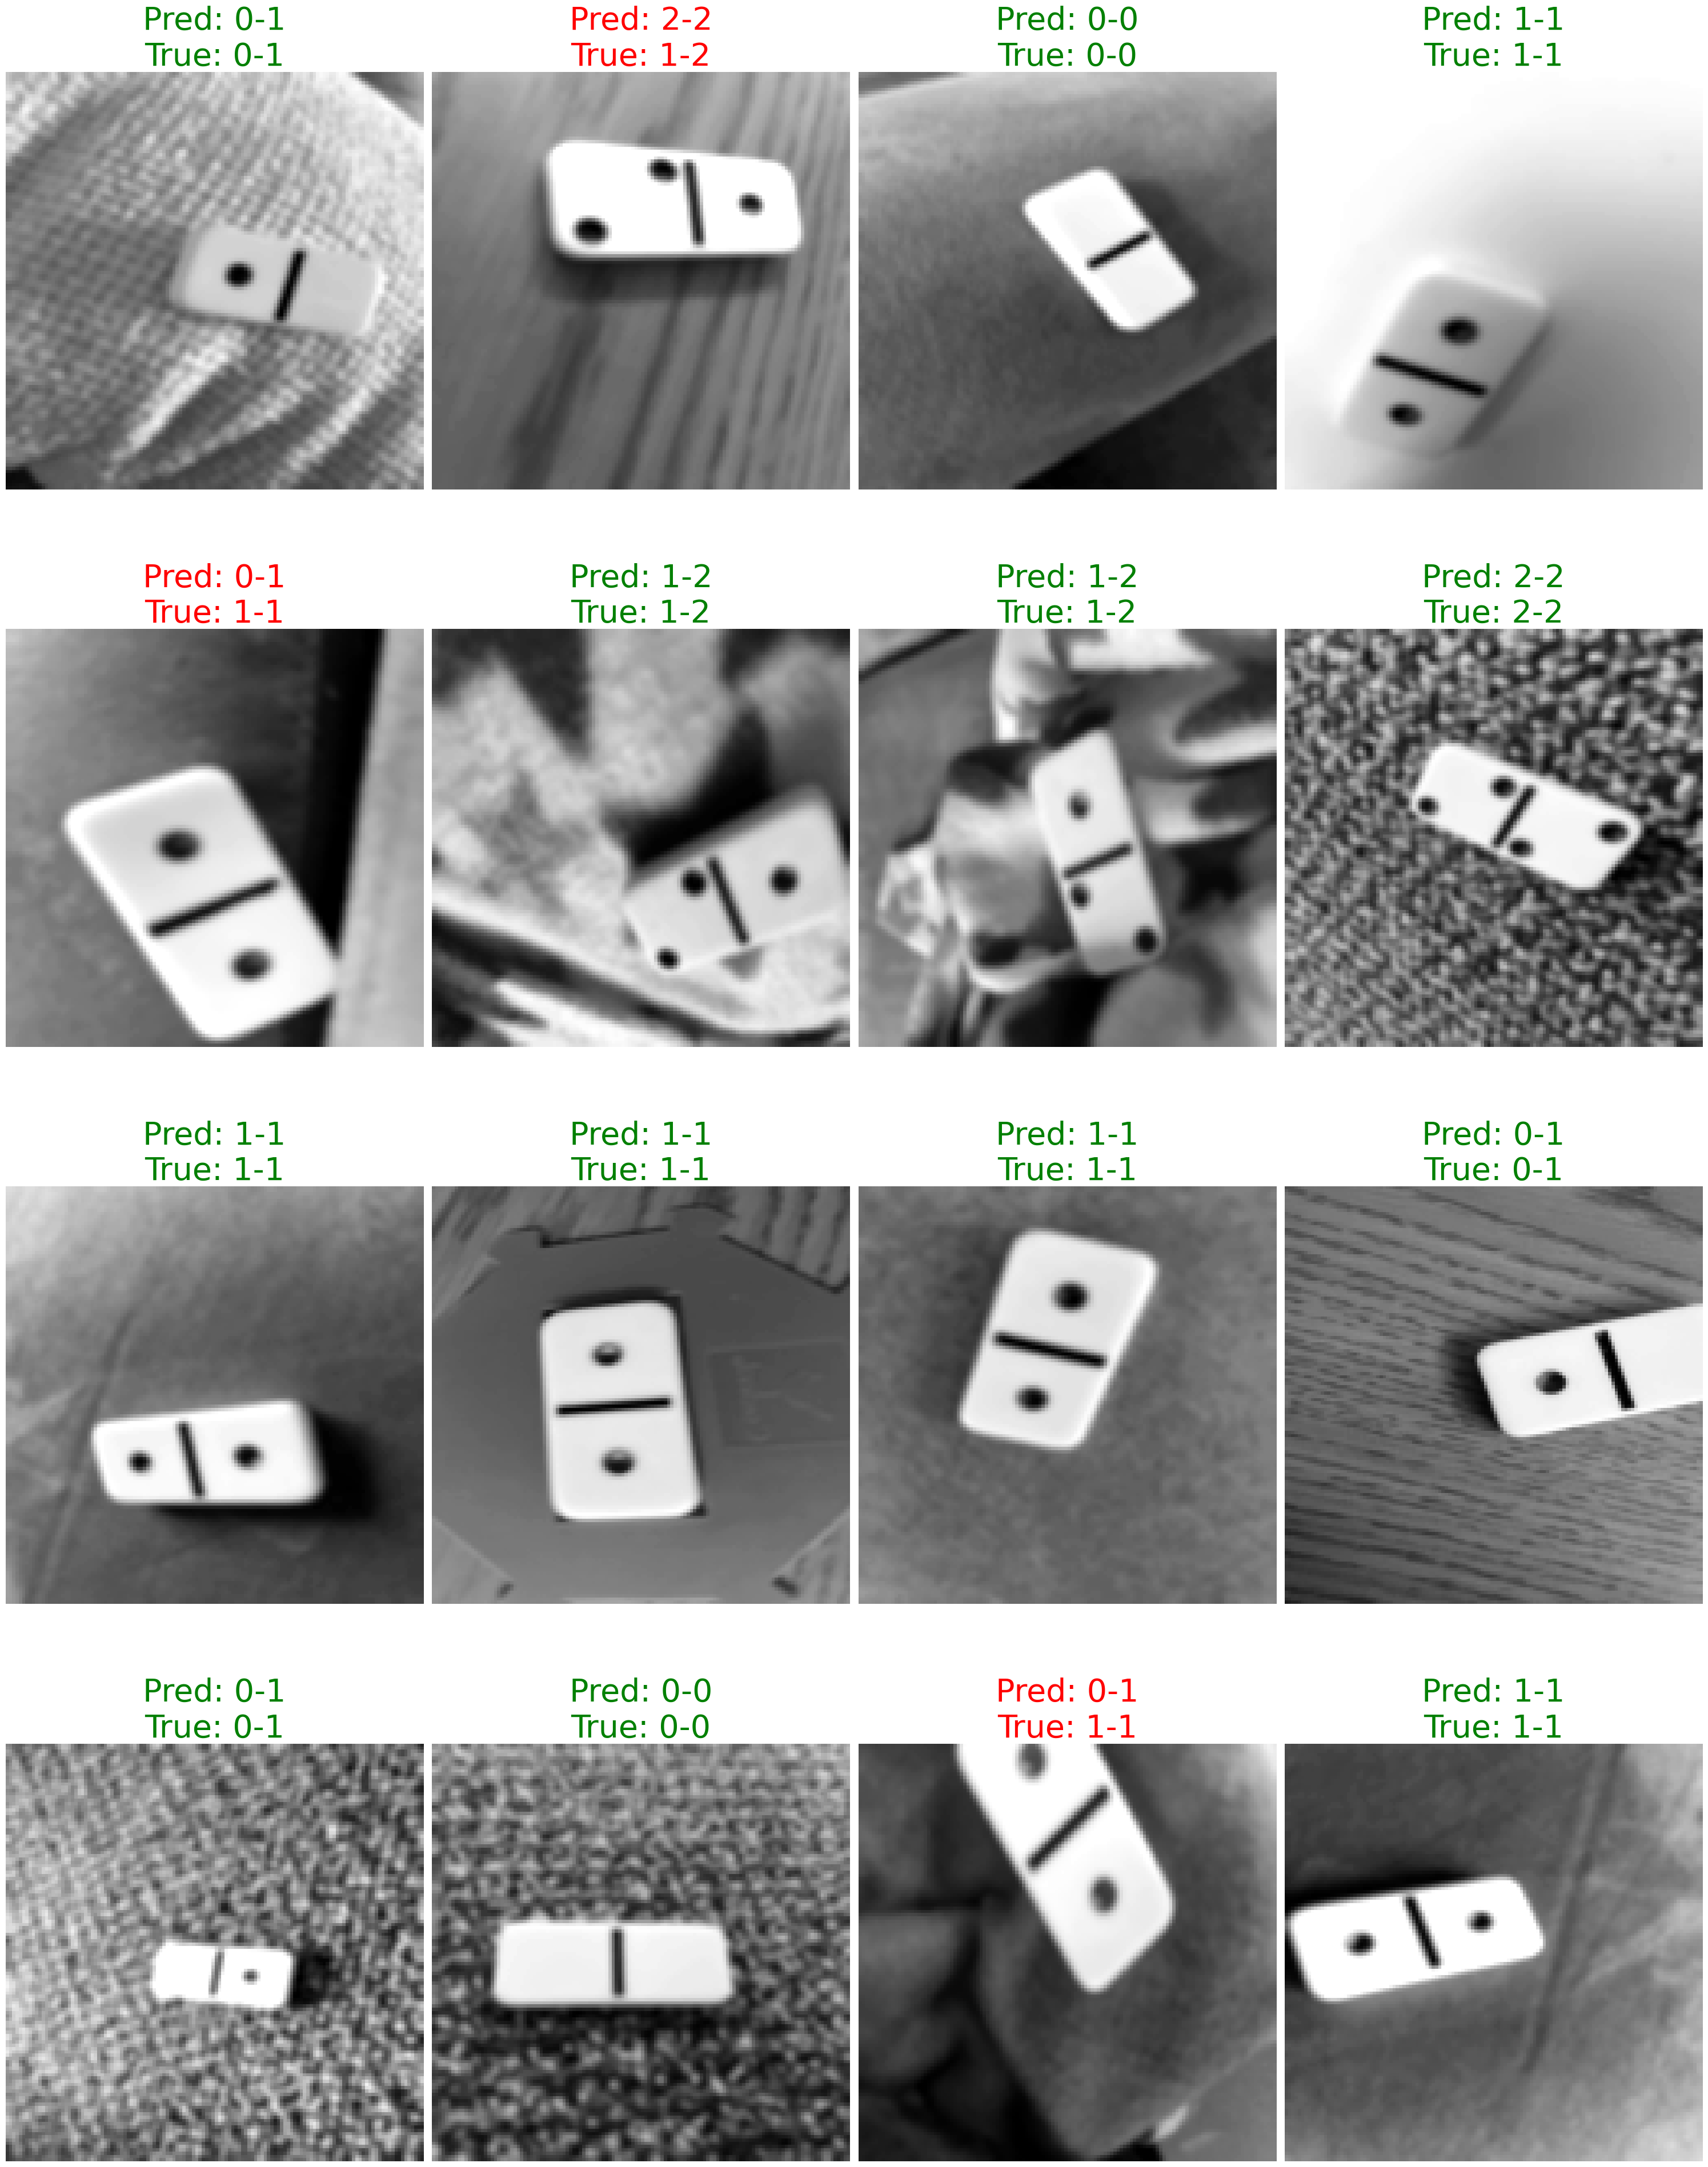

In [40]:
# Visualize test predictions
def visualize_predictions(model, test_loader, class_names, num_images=32):
    model.eval()  # Set model to evaluation mode
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    
    images, labels = next(iter(test_loader))  # Get a batch of test images
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    images = images.cpu().numpy()
    
    # Denormalize images for visualization
    images = images * 0.5 + 0.5

    fig, axes = plt.subplots(4, 4, figsize=(30, 40))  # Create a 4x4 grid
    axes = axes.flatten()

    for idx in range(num_images):
        img = images[idx].squeeze(0)  # Remove extra channel dimension
        axes[idx].imshow(img, cmap="gray")
        axes[idx].axis("off")
        
        # Get true and predicted labels
        true_label = class_names[labels[idx].item()]
        predicted_label = class_names[preds[idx].item()]
        
        # Set title with color coding
        color = "green" if true_label == predicted_label else "red"
        axes[idx].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color, fontsize=40)

    plt.tight_layout()
    plt.show()

# Define class names
class_names = ["0-0", "0-1", "0-2", "1-1", "1-2", "2-2"]

# visualize test predictions
test_loader_visual = DataLoader(test_dataset, batch_size=16, shuffle=True)
visualize_predictions(model, test_loader_visual, class_names, num_images=16)
